# Import Library

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
#from pycaret.regression import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
import math

In [73]:
df= pd.read_csv('BTC-USD.csv')
pd.set_option('display.max_columns', None)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


# Preprocessing and Cleaning

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2747 entries, 0 to 2746
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2747 non-null   object 
 1   Open       2747 non-null   float64
 2   High       2747 non-null   float64
 3   Low        2747 non-null   float64
 4   Close      2747 non-null   float64
 5   Adj Close  2747 non-null   float64
 6   Volume     2747 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 150.4+ KB


In [75]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

In [76]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [77]:
df.duplicated().sum()

0

In [78]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2747.000000,2747.000000,2747.000000,2747.000000,2747.000000,2.747000e+03
mean,11668.600272,11981.034949,11325.596907,11682.892098,11682.892098,1.484704e+10
std,16323.683853,16759.568657,15825.584507,16330.191582,16330.191582,1.994819e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,609.122009,611.894501,606.309479,609.234009,609.234009,8.161285e+07
50%,6371.850098,6500.870117,6285.629883,6376.709961,6376.709961,5.227550e+09
75%,10728.271485,10992.468751,10412.890137,10755.395019,10755.395019,2.500517e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


# Scaling Data

In [79]:
df= df["Close"]

In [80]:
## Mengubah bentuknya kedalam numpy array 
dataset = df.values
dataset = dataset.astype('float32')
dataset

array([  457.334,   424.44 ,   394.796, ..., 42892.957, 43960.934,
       44395.965], dtype=float32)

In [81]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
dataset = min_max_scaler.fit_transform(df.values.reshape(-1, 1))
dataset

array([[0.00414359],
       [0.00365546],
       [0.00321557],
       ...,
       [0.63385758],
       [0.64970558],
       [0.65616113]])

In [82]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print(len(train), len(test))

1840 907


In [83]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [84]:
look_back = 10
trainX, trainY = create_dataset(train, look_back=look_back)
testX, testY = create_dataset(test, look_back=look_back)

In [85]:
trainX

array([[0.00414359, 0.00365546, 0.00321557, ..., 0.00363714, 0.00346454,
        0.00335845],
       [0.00365546, 0.00321557, 0.00342492, ..., 0.00346454, 0.00335845,
        0.00328567],
       [0.00321557, 0.00342492, 0.0032753 , ..., 0.00335845, 0.00328567,
        0.00295417],
       ...,
       [0.14933017, 0.14869171, 0.14970326, ..., 0.12528006, 0.12329793,
        0.1178367 ],
       [0.14869171, 0.14970326, 0.14844529, ..., 0.12329793, 0.1178367 ,
        0.11980851],
       [0.14970326, 0.14844529, 0.14604244, ..., 0.1178367 , 0.11980851,
        0.1197205 ]])

In [86]:
trainY

array([0.00328567, 0.00295417, 0.00292874, ..., 0.11980851, 0.1197205 ,
       0.11761734])

In [87]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Build Model

In [90]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=256, verbose=2)

Epoch 1/100
8/8 - 3s - loss: 5.7965e-04 - 3s/epoch - 408ms/step
Epoch 2/100
8/8 - 0s - loss: 3.4155e-04 - 17ms/epoch - 2ms/step
Epoch 3/100
8/8 - 0s - loss: 2.7875e-04 - 17ms/epoch - 2ms/step
Epoch 4/100
8/8 - 0s - loss: 1.9201e-04 - 16ms/epoch - 2ms/step
Epoch 5/100
8/8 - 0s - loss: 1.3757e-04 - 17ms/epoch - 2ms/step
Epoch 6/100
8/8 - 0s - loss: 1.0249e-04 - 17ms/epoch - 2ms/step
Epoch 7/100
8/8 - 0s - loss: 8.0258e-05 - 16ms/epoch - 2ms/step
Epoch 8/100
8/8 - 0s - loss: 7.0613e-05 - 17ms/epoch - 2ms/step
Epoch 9/100
8/8 - 0s - loss: 6.7098e-05 - 17ms/epoch - 2ms/step
Epoch 10/100
8/8 - 0s - loss: 6.6522e-05 - 16ms/epoch - 2ms/step
Epoch 11/100
8/8 - 0s - loss: 6.6268e-05 - 16ms/epoch - 2ms/step
Epoch 12/100
8/8 - 0s - loss: 6.5878e-05 - 16ms/epoch - 2ms/step
Epoch 13/100
8/8 - 0s - loss: 6.5883e-05 - 17ms/epoch - 2ms/step
Epoch 14/100
8/8 - 0s - loss: 6.5222e-05 - 18ms/epoch - 2ms/step
Epoch 15/100
8/8 - 0s - loss: 6.5066e-05 - 17ms/epoch - 2ms/step
Epoch 16/100
8/8 - 0s - loss: 6.53

# Predicting

In [95]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert Predicting

In [96]:
trainPredict = min_max_scaler.inverse_transform(trainPredict)
trainY = min_max_scaler.inverse_transform([trainY])
testPredict = min_max_scaler.inverse_transform(testPredict)
testY = min_max_scaler.inverse_transform([testY])

# Root mean squared error

In [99]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 385.79 RMSE
Test Score: 8773.16 RMSE


In [100]:

print("Train shape:", trainPredict.shape)
print("Test shape:", testPredict.shape)

Train shape: (1829, 1)
Test shape: (896, 1)


# Shifting train and test predictions for plotting

In [101]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict
 

In [102]:
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2) + 1:len(dataset) - 1, :] = testPredict

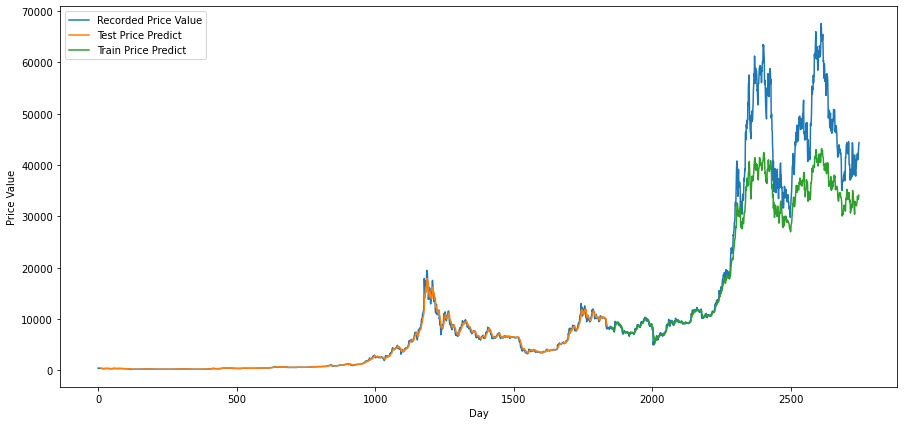

In [106]:
plt.figure(figsize=(15,7))
plt.plot(min_max_scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend(["Recorded Price Value", "Test Price Predict", "Train Price Predict" ], loc=2)
plt.ylabel('Price Value')
plt.xlabel('Day')
plt.show()